In [191]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to C:\Users\Vrooh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vrooh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vrooh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
# 2. Load Dataset
dfb = pd.read_csv('dataset_init.csv')
dfb.head()

,review,sentiment
0,"enjoyable, though it gets worse once you get t...",positive
1,good game,positive
2,I confirmed that the residents of the house ar...,positive
3,"This game was a real surprise, it pretty much ...",positive
4,great game I was reluctant to play as I had hi...,positive


In [193]:
# 2. Daftar kata-kata yang menunjukkan review "netral"
neutral_keywords = ['ok', 'fine', 'decent', 'not bad', 'good enough', 'good game', 'average', 'mediocre', 'acceptable', 'satisfactory', 'not great', 'not terrible']

# 3. Daftar ID (atau indeks) yang mau diubah manual ke netral
# Kalau tidak ada, kosongkan list ini
manual_neutral_ids = []

# 4. Threshold jumlah kata untuk dianggap netral
min_words_netral = 2
max_words_netral = 5

# 5. Fungsi relabel gabungan
def relabel(row):
    text = str(row['review']).lower()
    num_words = len(text.split())
    
    # Prioritas 1: Jika ID ada di daftar manual override
    # if row.name in manual_neutral_ids:
    #     return 'Neutral'  # Netral
    
    # Prioritas 2: Jika mengandung kata netral
    if any(keyword in text for keyword in neutral_keywords):
        return 'Neutral'  # Netral

    # Prioritas 3: Jika panjang kalimat pendek (ambiguous review)
    # if min_words_netral <= num_words <= max_words_netral:
    #     return 'Neutral'  # Netral
    
    # Kalau tidak memenuhi semua di atas, pakai label asli
    return row['sentiment']

# 6. Terapkan fungsi relabel
dfb['new_sentiment'] = dfb.apply(relabel, axis=1)

# 7. Simpan ke file baru
dfb.to_csv('dataset_relabelled.csv', index=False)

print("Relabeling selesai! Dataset baru disimpan di 'dataset_relabelled.csv'.")

Relabeling selesai! Dataset baru disimpan di 'dataset_relabelled.csv'.


In [194]:
# 2. Load Dataset
df = pd.read_csv('dataset_relabelled.csv')
df.head()

,review,sentiment,new_sentiment
0,"enjoyable, though it gets worse once you get t...",positive,positive
1,good game,positive,Neutral
2,I confirmed that the residents of the house ar...,positive,positive
3,"This game was a real surprise, it pretty much ...",positive,positive
4,great game I was reluctant to play as I had hi...,positive,positive


In [195]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Menangani NaN dan tipe data non-string
    if not isinstance(text, str):
        return ''  # Kembalikan string kosong jika bukan string
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus karakter selain huruf dan spasi
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Terapkan preprocessing pada kolom 'review'
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Menampilkan hasil
print(df.head())

                                              review sentiment new_sentiment  \
0  enjoyable, though it gets worse once you get t...  positive      positive   
1                                          good game  positive       Neutral   
2  I confirmed that the residents of the house ar...  positive      positive   
3  This game was a real surprise, it pretty much ...  positive      positive   
4  great game I was reluctant to play as I had hi...  positive      positive   

                                      cleaned_review  
0  enjoyable though gets worse get halfway point ...  
1                                          good game  
2              confirmed residents house infact evil  
3  game real surprise pretty much saved resident ...  
4  great game reluctant play high expectations re...  


In [196]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review']).toarray()
y = df['new_sentiment'].map({'positive':1, 'negative':0, 'Neutral':2}).values

In [197]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [199]:
# 4. Model Building (Deep Learning)
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

# 5. Training
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

class_weights = {0: 2, 1: 1, 2: 2}  # Sesuaikan dengan distribusi kelas
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

c:\Users\Vrooh\anaconda3\envs\submission-analysis\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8265 - loss: 0.7370 - weighted_accuracy: 0.7621 - val_accuracy: 0.9051 - val_loss: 0.2733 - val_weighted_accuracy: 0.9051
Epoch 2/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9283 - loss: 0.3107 - weighted_accuracy: 0.9111 - val_accuracy: 0.8959 - val_loss: 0.2870 - val_weighted_accuracy: 0.8959
Epoch 3/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9577 - loss: 0.2101 - weighted_accuracy: 0.9478 - val_accuracy: 0.9099 - val_loss: 0.2737 - val_weighted_accuracy: 0.9099
Epoch 4/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9720 - loss: 0.1436 - weighted_accuracy: 0.9650 - val_accuracy: 0.9086 - val_loss: 0.3122 - val_weighted_accuracy: 0.9086
Epoch 5/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9807 - loss: 0.1071 - weighted_accuracy: 0.9757 - val_accuracy: 0.9100 - val_loss: 0.3550 - val_weighted_accuracy: 0.9100
Epoch 6/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/s

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.4472 - weighted_accuracy: 0.9073
Test Accuracy: 90.65%
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.37      0.44       287
           1       0.93      0.96      0.94      5267
           2       0.88      0.80      0.84      1314

    accuracy                           0.91      6868
   macro avg       0.78      0.71      0.74      6868
weighted avg       0.90      0.91      0.90      6868



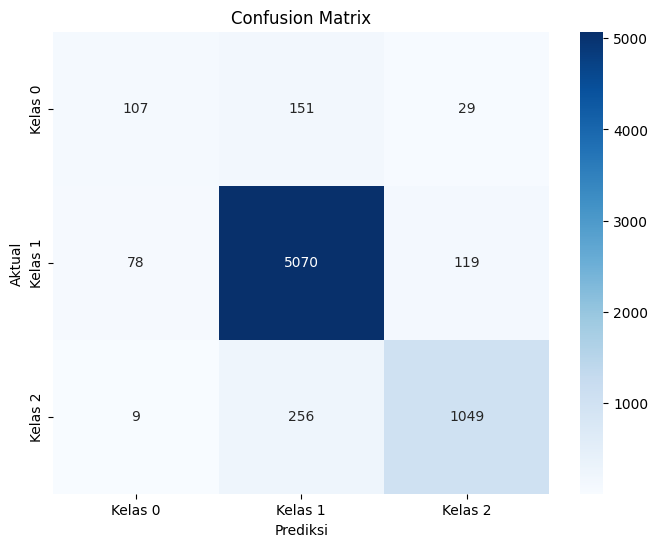

In [200]:
# 8. Evaluasi
# Pastikan untuk menangkap semua nilai yang dikembalikan oleh evaluate()
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]

# Jika ada metrik tambahan (misalnya weighted_accuracy), Anda dapat menambahkan:
# weighted_accuracy = results[2] # Sesuaikan dengan urutan metrik yang ada

print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Prediksi kelas untuk X_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# Konversi y_test ke label kelas (sama dengan prediksi)
y_test_labels = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test_labels, y_pred))

# Hitung confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Kelas 0', 'Kelas 1', 'Kelas 2'], yticklabels=['Kelas 0', 'Kelas 1', 'Kelas 2'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()


In [202]:
# 9. Inference (Opsional Biar Nilai Tinggi)
def predict_sentiment(text):
    cleaned = preprocess_text(text)  # Pembersihan teks
    vect_text = vectorizer.transform([cleaned]).toarray()  # Transformasi teks menjadi fitur
    prediction = model.predict(vect_text)  # Hasil prediksi model
    
    # Dapatkan probabilitas untuk setiap kelas
    positive_prob = prediction[0][1]
    neutral_prob = prediction[0][2]
    negative_prob = prediction[0][0]
    
    print(f"Probabilities - Positive: {positive_prob}, Neutral: {neutral_prob}, Negative: {negative_prob}")
    
    # Tentukan kelas berdasarkan probabilitas tertinggi
    if positive_prob > neutral_prob and positive_prob > negative_prob:
        return "Positive"
    elif neutral_prob > positive_prob and neutral_prob > negative_prob:
        return "Neutral"
    else:
        return "Negative"


# Test Sampel
sample_1 = "This game is awesome!"
sample_2 = "good game"
sample_3 = "Stupid game, I hate it."

print(f"Predicted Sentiment for '{sample_1}': {predict_sentiment(sample_1)}")
print(f"Predicted Sentiment for '{sample_2}': {predict_sentiment(sample_2)}")
print(f"Predicted Sentiment for '{sample_3}': {predict_sentiment(sample_3)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilities - Positive: 0.9998998641967773, Neutral: 3.1582050723955035e-05, Negative: 6.857597327325493e-05
Predicted Sentiment for 'This game is awesome!': Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilities - Positive: 0.01239472720772028, Neutral: 0.9875984787940979, Negative: 6.843141818535514e-06
Predicted Sentiment for 'good game': Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Probabilities - Positive: 0.2801394760608673, Neutral: 0.012843495234847069, Negative: 0.7070171236991882
Predicted Sentiment for 'Stupid game, I hate it.': Negative
